<a href="https://colab.research.google.com/github/JCherryA050/phase_4_project/blob/main/anime_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title of the Analysis

**Authors:** 

## Overview

This is where an overview of the problem statement and a breif description of the analysis would go.

## Business Problem

Explain the business problem and include relevant sources to fully describe what the problem is, how it can be solved using models, and what is trying to be determined by the models. include background on the issue and related studies.

## Data Understanding

Describe where the data came from and how it relates to the business problem above. Give links to the data, a table with the relevant features and descriptions and links to other studies that give more information on the data set itself.

### Importing Packages and Loading the Datasets

In [ ]:
#Import standard packages for data engineering and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, datetime
import pickle

#import packages to support geo visuals
import folium
from folium.plugins import HeatMap
import json

#Import packages to perform linear regression modeling and preprocessing tools
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise.reader import Reader

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Import local functions from src/
import sys
sys.path.insert(0, 'src/')

#Ignore warnings in cells
import warnings
warnings.filterwarnings('ignore')
mpl.style.use('fivethirtyeight')


In [ ]:
# Import all related data sets
# anime_list_df = pd.read_csv('../../data/animelist.csv')
# anime_df = pd.read_csv('../../data/anime.csv')
# anime_with_sin_df = pd.read_csv('../../data/anime_with_synopsis.csv')
# rating_comp_df = pd.read_csv('../../data/rating_complete.csv')
# watch_stat_df = pd.read_csv('../../data/watching_status.csv')
anime_list_df = pd.read_pickle('cleaned_anime_list.pkl')
# anime_df = pd.read_csv('../../data/anime.csv')

In [ ]:
anime_df = pd.read_pickle('cleaned_anime.pkl')

In [ ]:
anime_list_df = anime_list_df[anime_list_df['rating'] != 0]

In [ ]:
anime_list_df.to_pickle("../../data/cleaned_anime_list.pkl")

# Data Cleaning

In [ ]:
def split_and_take_min(x):
    lst = x.split(' ')
    nums = []
    for i in lst:
        try:
            nums.append(int(i))
        except:
            continue
    try:
        return int(nums[0])
    except:
        return 0
anime_df['Premiered'] = anime_df['Premiered'].apply(split_and_take_min)

In [ ]:
# remove the anime of ill repute
anime_df = anime_df[~anime_df['Genders'].str.contains("Hentai")]

# Remove all of the short films with air time under 1 minute
anime_df = anime_df[~anime_df['Duration'].str.contains("sec")]

# Remove all of the obscure anime types such as music videos
anime_df = anime_df[~anime_df['Type'].str.contains('|'.join(['Movie', 'Music', 'OVA', 'Special', 'ONA', 'Unknown']))]

# Take the top 14000 ranked anime
# anime_df = anime_df[anime_df['Popularity'] < 14000]

# # Filter out all of the anime that Aired before 1980
# anime_df = anime_df[anime_df['Premiered'] >= 1980]

# Clean the rankings list with the ID's of the remaining anime
cleaned_df = anime_list_df[anime_list_df['anime_id'].isin(list(anime_df['MAL_ID'].tolist()))]
cleaned_df = cleaned_df[anime_list_df['rating'] != 0]
# There is way too much data in this set so we will be resampling the data to 
# make a smaller data set.
# cleaned_df = cleaned_df.sample(100000)


In [ ]:
cleaned_df.to_pickle("../../data/cleaned_anime_list.pkl")

In [ ]:
anime_df.to_pickle("../../data/cleaned_anime.pkl")

### Get an understanding of the data

In [ ]:
# take a look at the datatypes
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4062 entries, 0 to 17520
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         4062 non-null   int64 
 1   Name           4062 non-null   object
 2   Score          4062 non-null   object
 3   Genders        4062 non-null   object
 4   English name   4062 non-null   object
 5   Japanese name  4062 non-null   object
 6   Type           4062 non-null   object
 7   Episodes       4062 non-null   object
 8   Aired          4062 non-null   object
 9   Premiered      4062 non-null   int64 
 10  Producers      4062 non-null   object
 11  Licensors      4062 non-null   object
 12  Studios        4062 non-null   object
 13  Source         4062 non-null   object
 14  Duration       4062 non-null   object
 15  Rating         4062 non-null   object
 16  Ranked         4062 non-null   object
 17  Popularity     4062 non-null   int64 
 18  Members        4062 non-nul

Thurough description of the key features, data types, possible problems that need to be solved with cleaning and some suggestions of feature engineering.

## Data Preparation

In [ ]:
#View the first 5 rows
anime_df.head()

,MAL_ID,Name,Score,Genders,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [ ]:
#check for duplicates in the data
anime_df[anime_df.duplicated()]

,MAL_ID,Name,Score,Genders,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1


We found no duplicate rows.

### Dealing with missing values 

In [ ]:
# Confirm the columns with missing values
anime_df.isna().sum()

MAL_ID           0
Name             0
Score            0
Genders          0
English name     0
Japanese name    0
Type             0
Episodes         0
Aired            0
Premiered        0
Producers        0
Licensors        0
Studios          0
Source           0
Duration         0
Rating           0
Ranked           0
Popularity       0
Members          0
Favorites        0
Watching         0
Completed        0
On-Hold          0
Dropped          0
Plan to Watch    0
Score-10         0
Score-9          0
Score-8          0
Score-7          0
Score-6          0
Score-5          0
Score-4          0
Score-3          0
Score-2          0
Score-1          0
dtype: int64

In [ ]:
# Fill NaN values according to appropriate method

Explanation of why NaN values were filled using specific method

### Looking at Distribution of Ratings

In [ ]:
cleaned_df['rating'].value_counts()

0     32448960
8     10917161
7      9505154
9      7488138
10     5102118
6      4814762
5      2524896
4      1219170
3       587105
2       339546
1       274990
Name: rating, dtype: int64

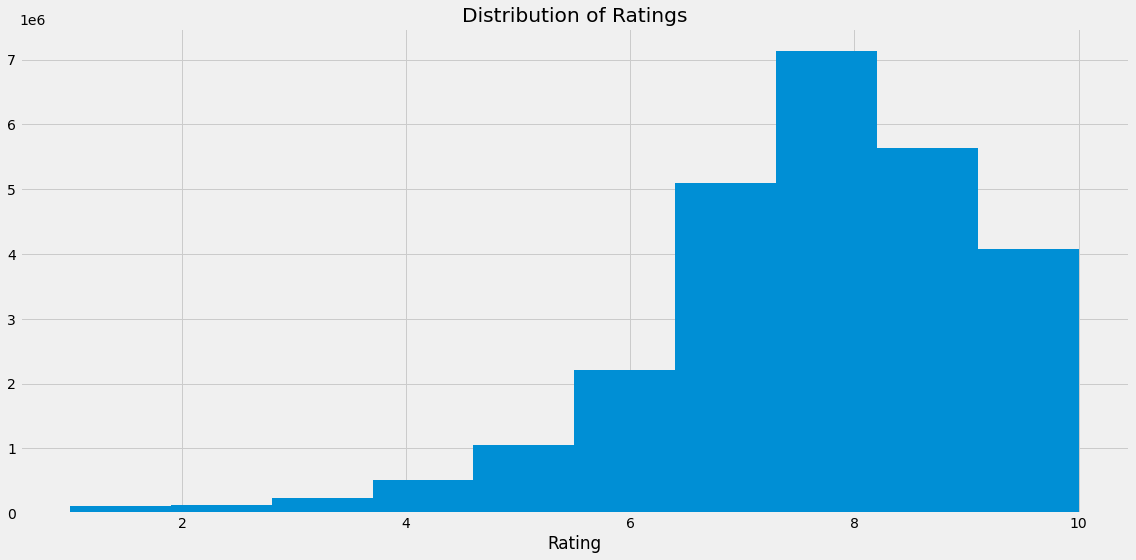

In [ ]:
mpl.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(anime_list_df['rating'], bins=10)
ax.set_title('Distribution of Ratings')
ax.set_xlabel('Rating')
plt.tight_layout()

#Save fig
fig.savefig('../../imgs/rating_dist.png');

In [ ]:
# Look at the mean and standard deviation of the ratings
ave = cleaned_df[cleaned_df['rating'] != 0]['rating'].mean()
stdev = cleaned_df[cleaned_df['rating'] != 0]['rating'].std()

In [ ]:
anime_df['Favorites']

0         61971
2         12944
9         29436
10        65586
11       126645
          ...  
16617      3027
16629      6925
16878      5059
17165      9065
17548         0
Name: Favorites, Length: 492, dtype: int64

### Looking at the Genres of Anime

In [ ]:
# Convert binary data to int type
df = df.loc[df['Score']!='Unknown',:]

In [ ]:
# Drop uneccesary columnsastype
genres = anime_df['Genders'].str.split(', ')

In [ ]:
genres_dict = {}
for row in genres:
  for i in row:
    i.replace(',','')
    if i in genres_dict.keys():
      genres_dict[i] += 1
    else:
      genres_dict[i] = 0

In [ ]:
len(genres_dict.keys())

38

In [ ]:
!pip install wordcloud

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

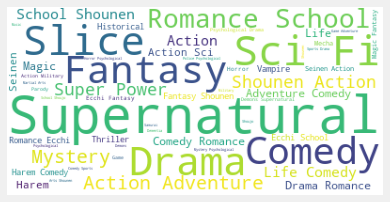

In [ ]:
# 
lst = []
for i in genres:
    lst += i
all_genres = ' '.join(lst)

# Create the wordcloud object
wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate(all_genres)

# Plotting the word cloud
fig,ax = plt.subplots()
plt.imshow(wordcloud, interpolation=None)
plt.axis("off")
plt.show()
fig.savefig('../../imgs/genres_cloud.png');

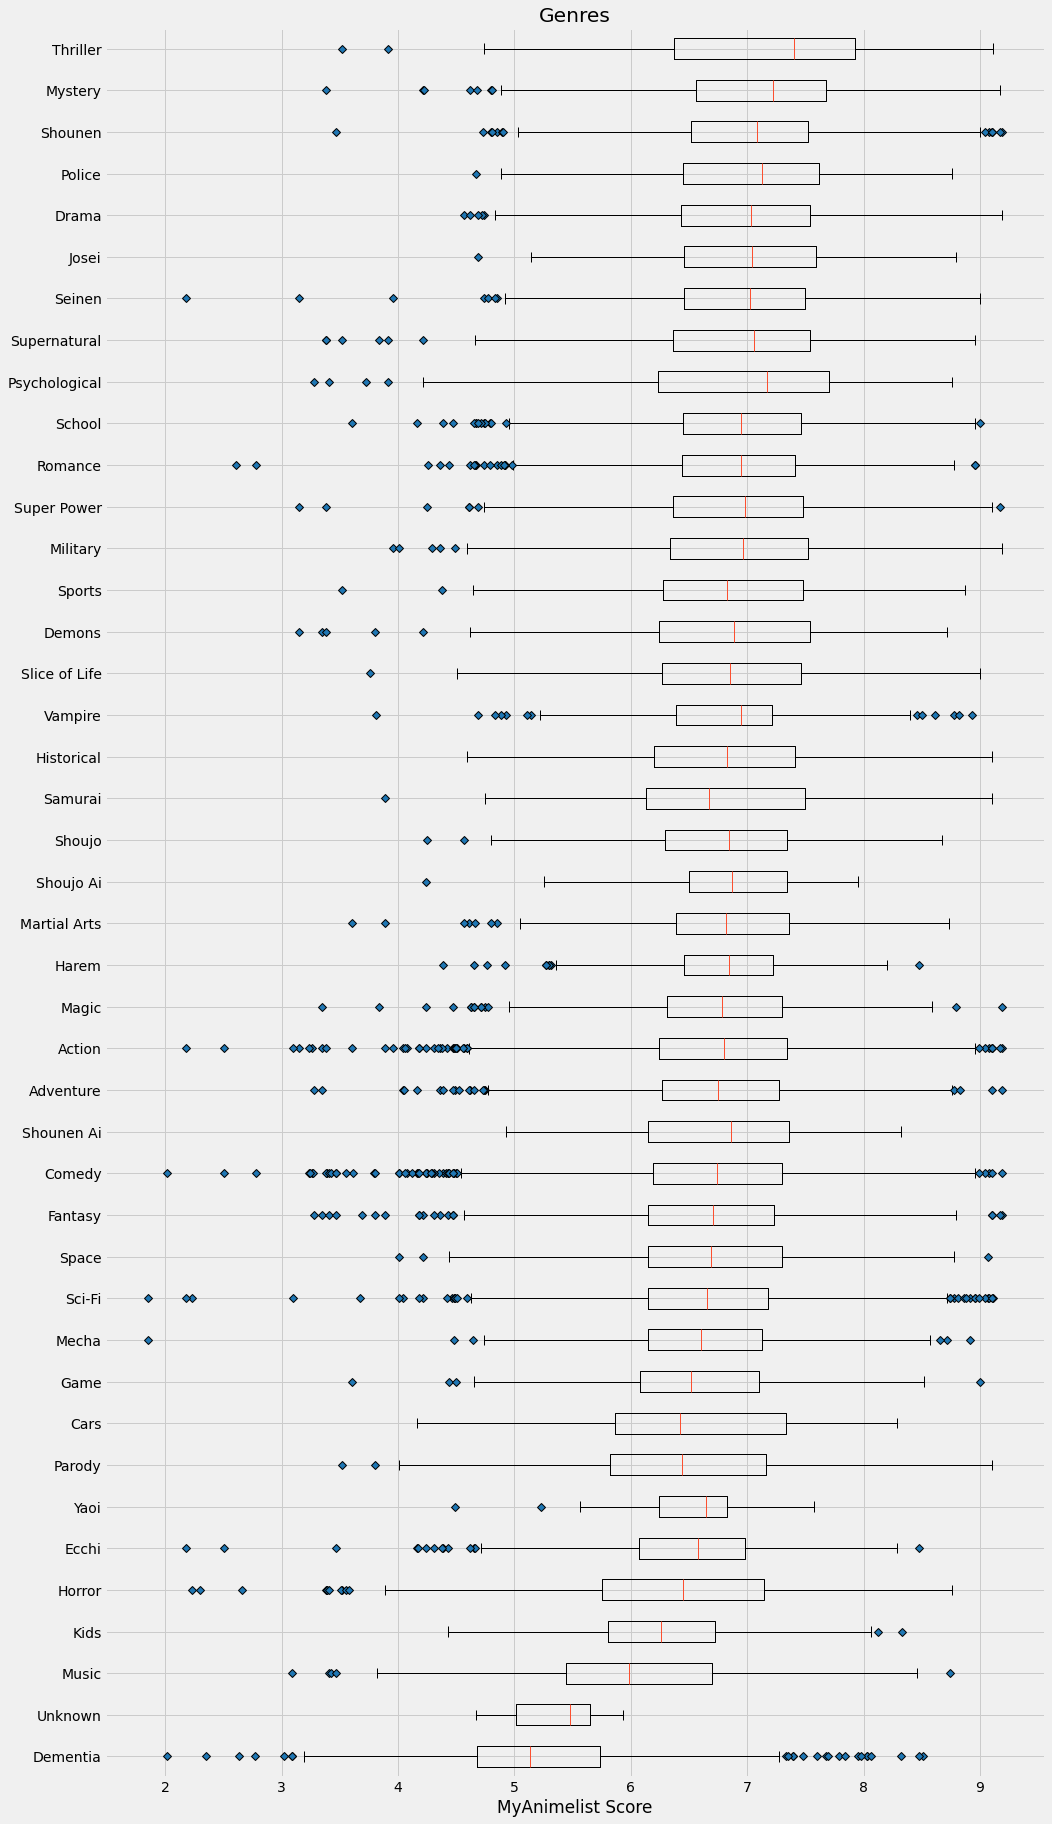

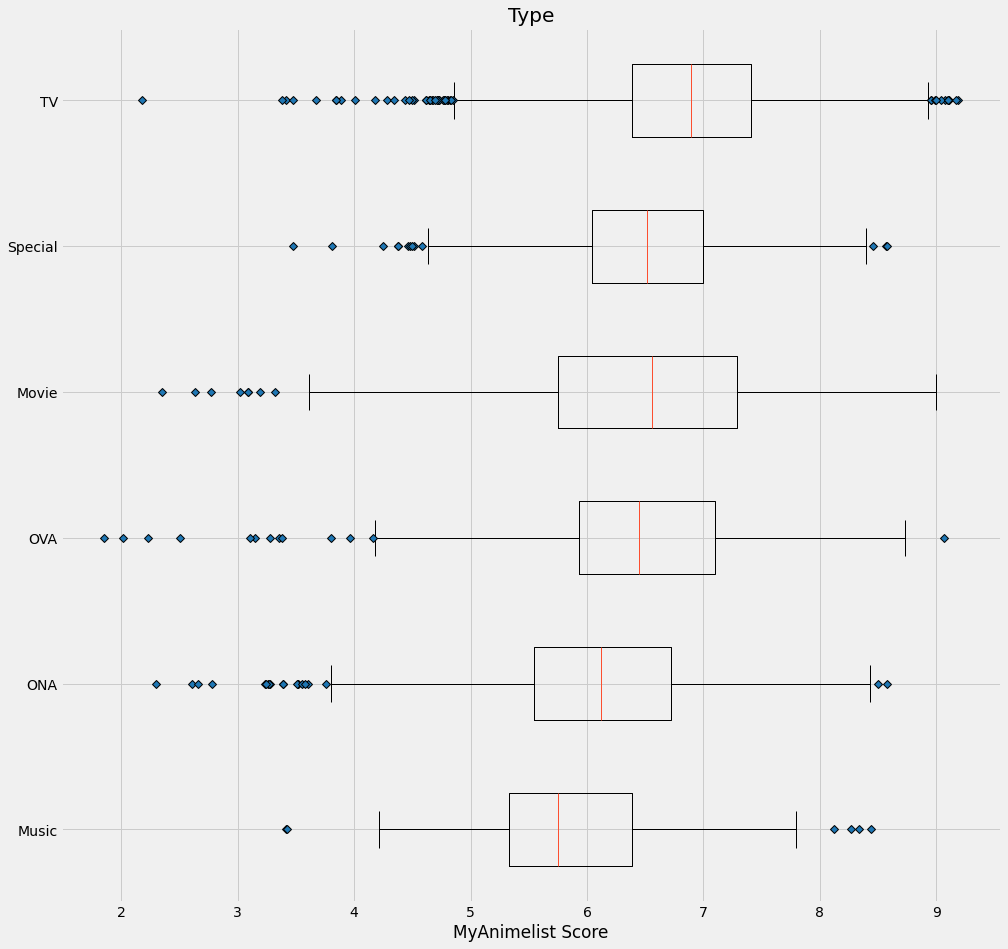

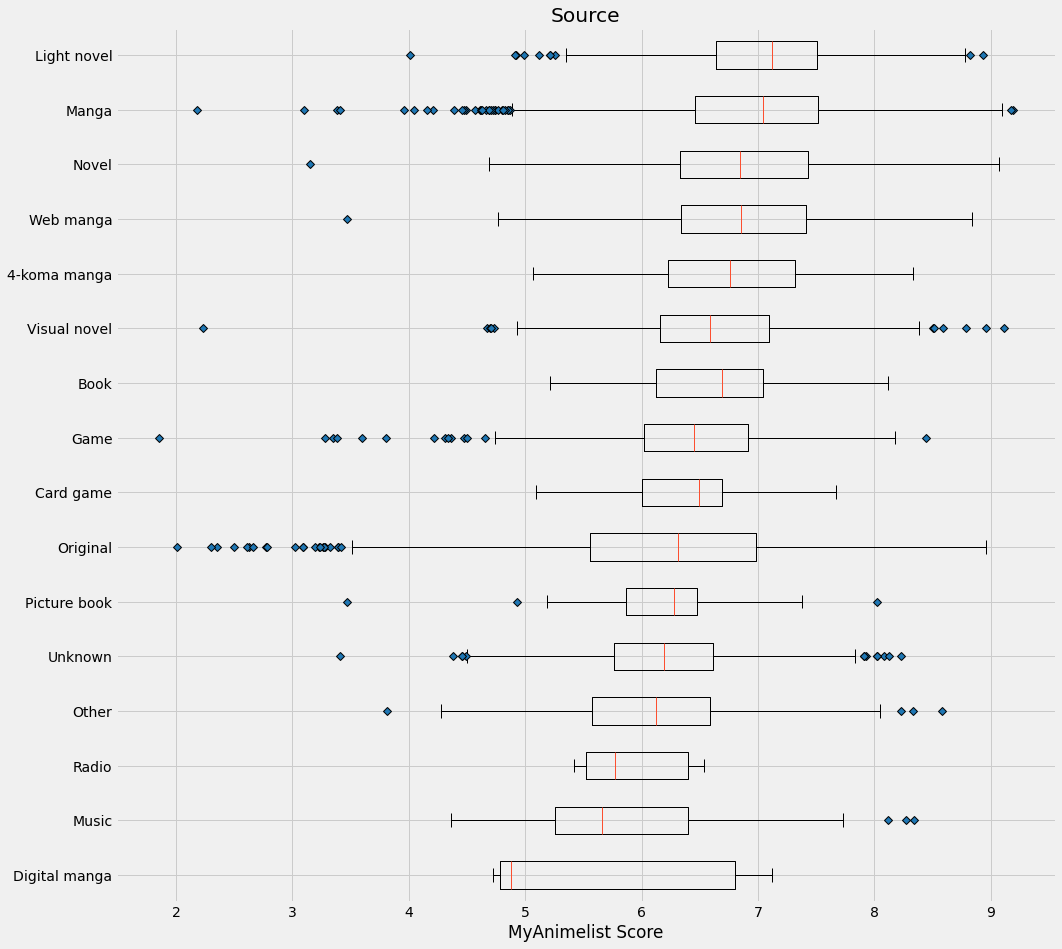

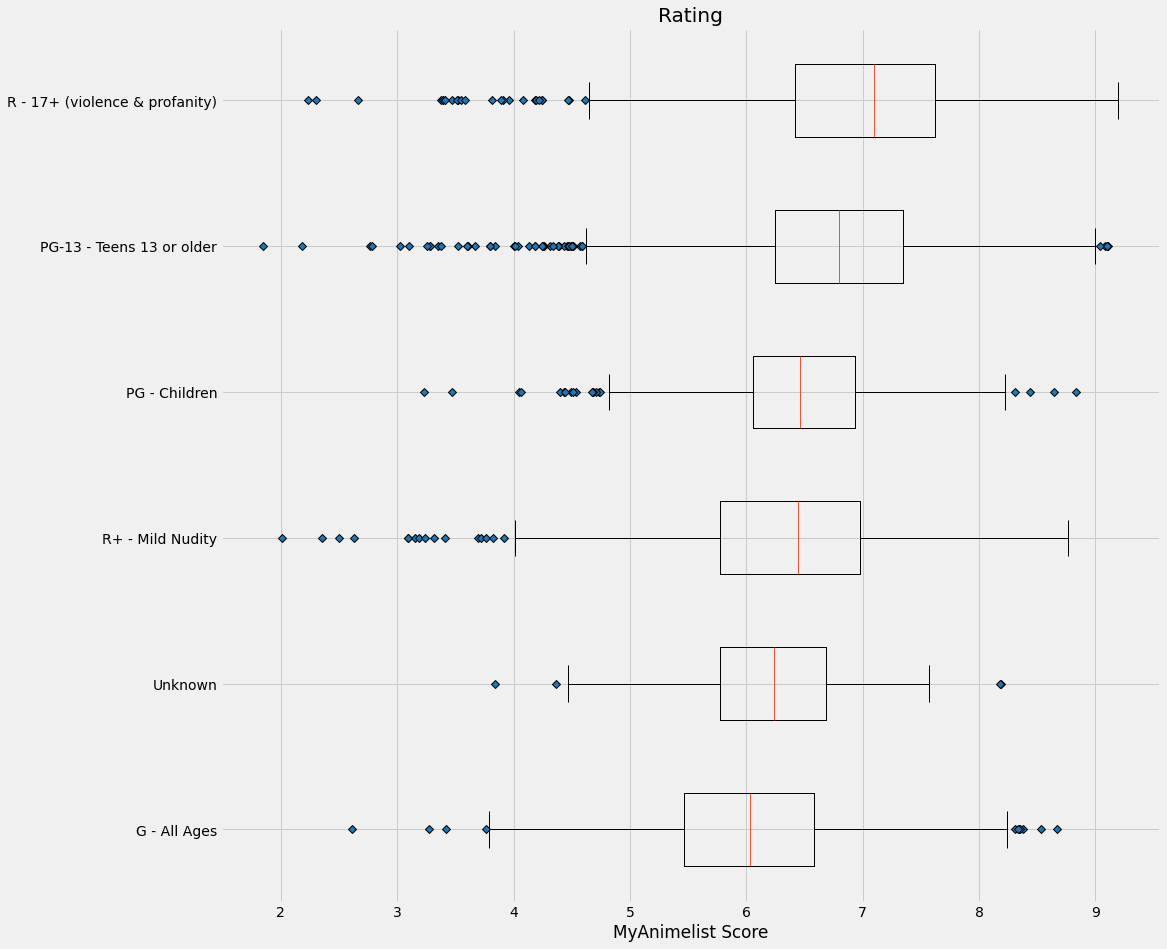

In [ ]:
all_data = pd.read_csv("../../data/anime.csv", dtype=str)
all_data = all_data[~all_data['Genders'].str.contains("Hentai")]

###################################### Plots

score_var  = 'Score'
for f in ['Genders', 'Type', 'Source', 'Rating'] :
  all_data[f] = all_data[f].str.split(', ')
  datas = defaultdict(list)
  for score, types in zip( all_data[score_var], all_data[f] ):
    if score == "Unknown": continue
    for type in types :
      datas[ type ] += [ float(score) ]

  sorted_datas = sorted(datas.items(), key=lambda f : sum(f[1])/len(f[1]) )


  fig, ax = plt.subplots(figsize=(15,15))
  ax.set_title( f )
  if f == "Genders" : 
    ax.set_title( "Genres" )
    fig.set_figheight( 2*fig.get_figheight() )
  ax.boxplot( [f[1] for f in sorted_datas], vert=False, flierprops=dict(markerfacecolor='tab:blue', marker='D') )
  ax.set_yticklabels( [f[0] for f in sorted_datas] )
  ax.set_xlabel('MyAnimelist Score')
  fig.savefig('../../imgs/'+f+'_boxplots.png')
  plt.show()

## Look at the year aired

In [ ]:
def split_and_take_min(x):
    lst = x.split(' ')
    nums = []
    for i in lst:
        try:
            nums.append(int(i))
        except:
            continue
    try:
        return int(nums[0])
    except:
        return 0
anime_df['Premiered'] = anime_df['Premiered'].apply(split_and_take_min)    

In [ ]:
anime_df[anime_df['Premiered'] >= 1980]

,MAL_ID,Name,Score,Genders,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",Unknown,アイシールド21,TV,145,"Apr 6, 2005 to Mar 19, 2008",2005,...,9226.0,14904.0,22811.0,16734.0,6206.0,2621.0,795.0,336.0,140.0,151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17551,48442,Shikaru Neko,Unknown,Slice of Life,Unknown,しかるねこ,TV,Unknown,"Apr, 2021 to ?",2021,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17553,48466,Kyoukai Senki,Unknown,"Action, Mecha",Unknown,境界戦機,TV,Unknown,"Oct, 2021 to ?",2021,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17554,48470,D_Cide Traumerei,Unknown,"Action, Adventure, Drama, Magic, Fantasy",Unknown,D_CIDE TRAUMEREI（ディーサイドトロイメライ）,TV,Unknown,"Jul, 2021 to ?",2021,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
17559,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,Unknown,"Jul, 2021 to ?",2021,...,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


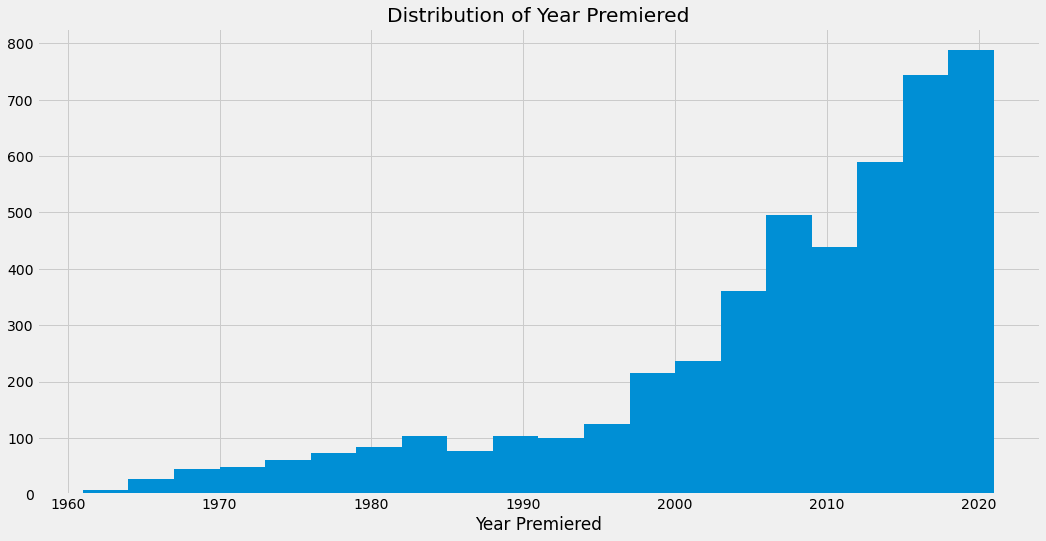

In [ ]:
fig,ax = plt.subplots(figsize=(16,8))

ax.hist(year,bins=20)
ax.set_title('Distribution of Year Premiered')
ax.set_xlabel('Year Premiered')
fig.savefig('../../imgs/dist_year_premiered.png')


## Look at the number of items and number of users in the ratings dataset

In [ ]:
# Looking at the number of users and the number of items in the rankings dataset
user_num = cleaned_df['user_id'].value_counts().shape[0]
item_num = cleaned_df['anime_id'].value_counts().shape[0]


In [ ]:
# print out the numbers in a table
print('Number of users: ', user_num, '\n')
print('Number of items: ', item_num)


Number of users:  324482 

Number of items:  4962


|||
|:------|:-------|
|Users|325176|
|Items|15780|

- There are significantly more users than items. We'll take that into account when inputting the specifications to our similarity metrics. Because we have fewer items than users, it will be more efficient to calculate item-item similarity rather than user-user similarity

## Look at the numbers of different producers, genres, Licensors, Studios

In [ ]:
anime_df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genders', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [ ]:
num_producers_2020 = anime_df[anime_df['Premiered'].str.contains('2020')]['Producers'].value_counts().shape[0]
# num_License_2020 = anime_df[anime_df['Premiered'].str.contains('2020')]['Licensors'].value_counts().shape[0]
num_Studio_2020 = anime_df[anime_df['Premiered'].str.contains('2020')]['Studios'].value_counts().shape[0]
num_Title_2020 = anime_df[anime_df['Premiered'].str.contains('2020')]['Name'].value_counts().shape[0]

print('Producers in 2020: ',num_producers_2020)
# print('Licensures in 2020: ',num_License_2020)
print('Studios in 2020: ',num_Studio_2020)
print('Titles in 2020: ',num_Title_2020)

Producers in 2020:  123
Studios in 2020:  109
Titles in 2020:  191


In [ ]:
num_producers_2000 = anime_df[anime_df['Premiered'].str.contains('2000')]['Producers'].value_counts().shape[0]
# num_License_2000 = anime_df[anime_df['Premiered'].str.contains('2000')]['Licensors'].value_counts().shape[0]
num_Studio_2000 = anime_df[anime_df['Premiered'].str.contains('2000')]['Studios'].value_counts().shape[0]
num_Title_2000 = anime_df[anime_df['Premiered'].str.contains('2000')]['Name'].value_counts().shape[0]

print('Producers in 2000: ',num_producers_2000)
# print('Licensures in 2000: ',num_License_2000)
print('Studios in 2000: ',num_Studio_2000)
print('Titles in 2000: ',num_Title_2000)

Producers in 2000:  42
Studios in 2000:  28
Titles in 2000:  57


## Considering number of reviews per anime and user

In [ ]:
# group the data set by anime IDaggregating the count and plotting a bar graph of the number per ID
anime_review_count = cleaned_df.groupby('anime_id').count()

In [ ]:
anime_review_count.head()

,user_id,rating,watching_status,watched_episodes
anime_id,,,,
1,208,208,208,208
6,99,99,99,99
7,32,32,32,32
15,37,37,37,37
16,89,89,89,89


In [ ]:
# Sort the grouped id's by the number of reviews for each
anime_review_count_sorted = anime_review_count.sort_values('rating',ascending=False)


In [ ]:
anime_review_count_sorted.head()

,user_id,rating,watching_status,watched_episodes
anime_id,,,,
1535,238790,238790,238790,238790
16498,216767,216767,216767,216767
11757,209919,209919,209919,209919
5114,201611,201611,201611,201611
4224,196190,196190,196190,196190


In [ ]:
most_reviewed = list(anime_review_count_sorted.index)[:20]

In [ ]:
# anime_df.loc[anime_df['MAL_ID']==1535,['Name']].values[0][0]
anime_review_count_sorted.loc[1535,['rating']].values[0]

238790

In [ ]:
most_review_titles = []
for item in most_reviewed:
    name = anime_df.loc[anime_df['MAL_ID']==item,['Name']].values[0][0]
    num = anime_review_count_sorted.loc[item,['rating']].values[0]
    rate = anime_df.loc[anime_df['MAL_ID']==item,['Score']].values[0][0]
    most_review_titles.append( (name,num,rate) )
    

In [ ]:
most_review_titles_df = pd.DataFrame(most_review_titles,columns=['Name','N ratings','Ave. Rating'])

In [ ]:
most_review_titles_df

,Name,N ratings,Ave. Rating
0,Death Note,238790,8.63
1,Shingeki no Kyojin,216767,8.48
2,Sword Art Online,209919,7.25
3,Fullmetal Alchemist: Brotherhood,201611,9.19
4,Toradora!,196190,8.24
5,Angel Beats!,194652,8.15
6,Code Geass: Hangyaku no Lelouch,193770,8.72
7,Steins;Gate,192783,9.11
8,Naruto,180244,7.91
9,Mirai Nikki,178385,7.54


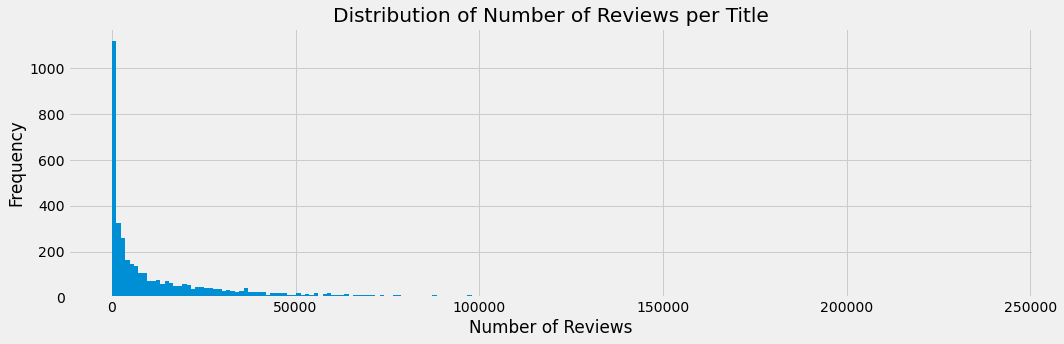

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(anime_review_count_sorted.rating,bins=200);
ax.set_title("Distribution of Number of Reviews per Title")
ax.set_xlabel("Number of Reviews")
ax.set_ylabel('Frequency')
plt.tight_layout()

fig.savefig('../../imgs/dist_review_count.png')


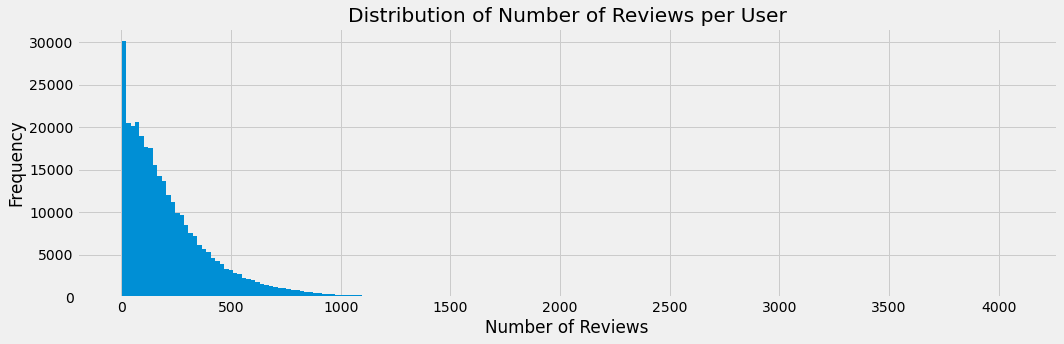

In [ ]:
# Group the ratings data by user and plot the distribution of ratings per user
user_review_count = cleaned_df.groupby('user_id').count()
user_review_count_sorted = anime_review_count.sort_values('rating',ascending=False)

fig,ax = plt.subplots(figsize=(15,5))
ax.hist(user_review_count.rating,bins=200);
ax.set_title("Distribution of Number of Reviews per User")
ax.set_xlabel("Number of Reviews")
ax.set_ylabel('Frequency')
plt.tight_layout()

fig.savefig('../../imgs/dist_user_review_count.png')

In [ ]:
user_review_count.sort_values('rating',ascending=False)

,anime_id,rating,watching_status,watched_episodes
user_id,,,,
20807,17546,17546,17546,17546
140590,17534,17534,17534,17534
281232,17533,17533,17533,17533
147331,17526,17526,17526,17526
131988,17520,17520,17520,17520
...,...,...,...,...
259248,1,1,1,1
259247,1,1,1,1
345120,1,1,1,1


In [ ]:
list(user_review_count_sorted.index)[:20]

[20807,
 140590,
 281232,
 147331,
 131988,
 122341,
 283786,
 312302,
 297931,
 85472,
 63900,
 50485,
 269633,
 189037,
 252520,
 92529,
 162615,
 173716,
 222150,
 68042]

In [ ]:

user_review_count_sorted = user_review_count.sort_values('rating',ascending=False)
most_review_user = list(user_review_count_sorted.index)[:5]

most_review = []
for item in most_review_user:
    
    name = item
    num = user_review_count_sorted.loc[item,['rating']].values[0]
    most_review.append( (name,num) )


In [ ]:
most_review_user_df = pd.DataFrame(most_review,columns=['User ID','N ratings'])
most_review_user_df

,User ID,N ratings
0,140590,4062
1,281232,4062
2,131988,4062
3,20807,4062
4,147331,4062


# Conclusions

**1. Best to sell homes from the northern side of King County, and waterfront homes.** Our analysis shows that as you move north in King County, homes tend to sell for a higher price. The prices also increase as you get closer to the big cities and closer to the waterfront.

**2. Recommend clients to renovate to increase property value.** Our analysis shows that renovated homes sell for a higher price than those homes not renovated. Our models show that renovating to increase square footage increases the sale price and consider adding extra bathrooms in the renovation as that also increases the price. Also consider improving the view of the home when renovating.

**3. Consider selling in the late spring, early summer.** The most homes wre sold in May for both years of our data. Homes tend to increase in sales during the spring and tend decrease slightly in the winter months.  

# Next Steps

Further analyses could provide even more insight into how you will advise your clients to buy or sell thier home. 

**Better idea of features of a home** Other features that indacate home sale include the color of the home, number of windows, garage indicator, size of garage, pool indicator, size of lawn, full property size, flood indicater, style of the home, among others.

**Better idea of neighborhood and surrounding neighborhoods.** We could gather more qualitative data on surrounding neighborhoods such as neighborhood safety, population demographics, and other idicators that may predict the price of a home. You could get an idea of proximity to schools, grocery stores, the city.

**Better idea of surrounding counties in Washington.** We could gather data from other counties and compare, county to county, how sale prices fluctuate. Other macro indicators of county could be political climate, social programs, broader proxiimity to major highways. 

**Better idea of sale history.** We had a fairly good sample of two years worth of data, but it would be good to gather even more years of sales data in King County further solidify reccomendations. There may be features of the home that are better at predicting sale price now then they were 5 or 10 years ago. 